In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import frykit.plot as fplt
import matplotlib.pyplot as plt
import numpy as np
from frykit.calc import region_mask
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from vfm_reader import VfmReader

In [2]:
# 读取文件
dirpath = Path("../data")
filepath = dirpath / "CAL_LID_L2_VFM-Standard-V4-21.2021-03-15T19-18-09ZN.hdf"
with VfmReader(filepath) as reader:
    lon = reader.lon
    lat = reader.lat
    time = reader.time
    height = reader.height
    fcf = reader.fcf

In [3]:
# 用地图显示范围截取数据
extents = [100, 120, 30, 45]
scan_mask = region_mask(lon, lat, extents, apply_and=True)
lon = lon[scan_mask]
lat = lat[scan_mask]
time = time[scan_mask]
fcf = fcf[scan_mask]
ftype = fcf[:, :, 0]

In [4]:
# 构造 cmap 和 norm
colors = [
    "white",
    "lightcyan",
    "skyblue",
    "gold",
    "red",
    "seagreen",
    "palegreen",
    "black",
]
ticklabels = [
    "invalid",
    "clear air",
    "cloud",
    "aerosol",
    "stratospheric\nfeature",
    "surface",
    "subsurface",
    "no signal",
]
cmap, norm, ticks = fplt.make_qualitative_palette(colors)

# 构造截面图所需的 x 轴刻度
x, xticks, xticklabels = fplt.get_cross_section_xticks(lon, lat, nticks=5)

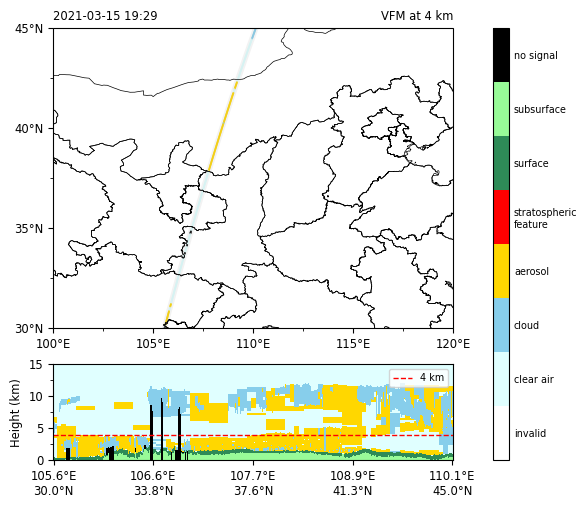

In [5]:
crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(8, 6))

# 绘制地图
ax1 = fig.add_axes([0.1, 0.4, 0.8, 0.5], projection=crs)
fplt.add_cn_province(ax1, lw=0.5)
ax1.coastlines(resolution="10m", lw=0.5)
fplt.set_map_ticks(ax1, extents, dx=5, dy=5, mx=1, my=1)

ax1.tick_params(labelsize="small")

# 画出 VFM 在 h0 高度的水平分布
h0 = 4
ind = np.nonzero(height <= h0)[0][-1]
ax1.plot(lon, lat, lw=4, c="gray", alpha=0.1, transform=crs)
ax1.scatter(lon, lat, c=ftype[:, ind], s=0.2, cmap=cmap, norm=norm, transform=crs)
mean_time = time.mean().strftime("%Y-%m-%d %H:%M")
ax1.set_title(mean_time, loc="left", fontsize="small")
ax1.set_title(f"VFM at {h0} km", loc="right", fontsize="small")

# 画出VFM 的垂直剖面
ax2 = fplt.add_side_axes(ax1, pad=0.06, width=0.16, loc="bottom")
pc = ax2.pcolormesh(x, height, ftype.T, cmap=cmap, norm=norm, shading="nearest")
ax2.axhline(h0, ls="--", c="r", lw=1, label=f"{h0} km")
ax2.legend(loc="upper right", fontsize="x-small")

# 设置 ax2 的坐标轴
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticklabels)
if filepath.stem[-1] == "N":
    ax2.invert_xaxis()
ax2.set_ylim(0, 15)
ax2.set_ylabel("Height (km)", fontsize="small")
ax2.yaxis.set_major_locator(MultipleLocator(5))
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.tick_params(labelsize="small")

# 设置 colorbar
cax = fplt.add_side_axes([ax1, ax2], pad=0.05, width=0.02, loc="right")
cbar = fig.colorbar(pc, cax=cax)
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticklabels)
cbar.ax.tick_params(length=0, labelsize="x-small")